In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

/Users/michal/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from datetime import datetime
from scipy.io import loadmat
from sklearn.utils import shuffle

In [3]:
train = loadmat('../data/train_32x32.mat')
test = loadmat('../data/test_32x32.mat')

In [4]:
print(train['X'].shape)
print(train['y'].shape)

(32, 32, 3, 73257)
(73257, 1)


## Visualize the data

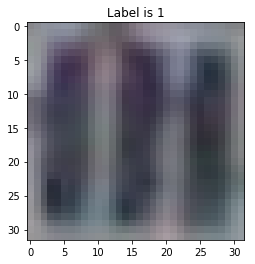

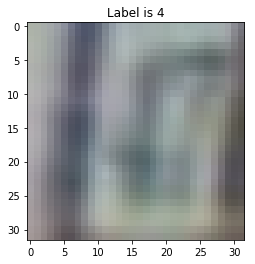

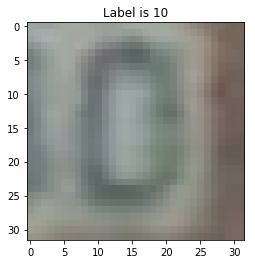

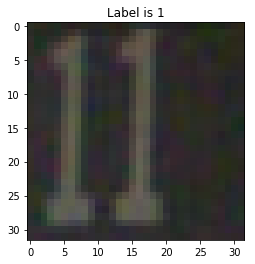

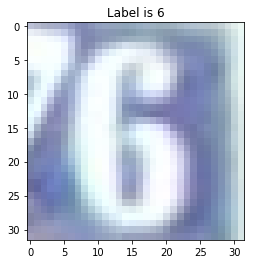

In [5]:
for i in range(5):
    rand_num = np.random.randint(0, train['X'].shape[-1])
    label = train['y'][rand_num][0]
    plt.title('Label is {label}'.format(label=label))
    plt.imshow(train['X'][:,:,:,rand_num])
    plt.show()

In [6]:
def rearange(X):
    # reshape and normalize
    return (X.transpose(3, 0, 1, 2)/255).astype(np.float32)

In [7]:
def one_hot(y):
    ind = np.zeros((len(y), len(set(y))))
    for i in range(len(y)):
        ind[i, y[i]] = 1
    return ind

In [8]:
Xtrain = rearange(train['X'])
Ytrain = one_hot(train['y'].flatten()-1)
Xtest = rearange(test['X'])
Ytest = one_hot(test['y'].flatten()-1)

In [9]:
print(Xtrain.shape)
print(Ytrain.shape)

(73257, 32, 32, 3)
(73257, 10)


In [10]:
max_iter = 10
print_period = 10
batch_sz = 500
n_batches = Xtrain.shape[0] // batch_sz

In [11]:
M1 = 512
M2 = 256
K = 10

In [12]:
# change input into tensor variable
X = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='X')
T = tf.placeholder(tf.float32, shape=(None, K), name='T')
Y = tf.placeholder(tf.int32, shape=(K), name='Y')

In [13]:
conv1 = tf.layers.conv2d(
      inputs=X,
      filters=20,
      kernel_size=[5, 5],
      padding="same",
      use_bias=True,
      kernel_initializer=tf.contrib.layers.xavier_initializer(),
      activation=tf.nn.relu)

In [14]:
conv1.shape

TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(20)])

In [15]:
# Pooling Layer 1: reduces 28x28 to 16x16
pool1 = tf.layers.max_pooling2d(
    inputs=conv1, 
    pool_size=[2, 2], 
    strides=2)

In [16]:
pool1.shape

TensorShape([Dimension(None), Dimension(16), Dimension(16), Dimension(20)])

In [17]:
# Convolutional Layer 2 and Pooling Layer 2: reduces 16x16 to 8x8
conv2 = tf.layers.conv2d(
  inputs=pool1,
  filters=64,
  kernel_size=[5, 5],
  padding="same",
  use_bias=True,
  kernel_initializer=tf.contrib.layers.xavier_initializer(),
  activation=tf.nn.relu)

In [18]:
conv2.shape

TensorShape([Dimension(None), Dimension(16), Dimension(16), Dimension(64)])

In [19]:
pool2 = tf.layers.max_pooling2d(
    inputs=conv2, 
    pool_size=[2, 2], 
    strides=2)

In [20]:
pool2.shape

TensorShape([Dimension(None), Dimension(8), Dimension(8), Dimension(64)])

In [21]:
# Dense Layer: we naow have 64, 8x8 filters we need to flatten
pool2_flat = tf.reshape(pool2, [-1, 8 * 8 * 64])
dense1 = tf.layers.dense(
    inputs=pool2_flat, 
    units=512, 
    activation=tf.nn.relu)
dropout1 = tf.layers.dropout(inputs=dense1, rate=0.4, training=False)

In [22]:
dense2 = tf.layers.dense(
    inputs=dropout1, 
    units=256, 
    activation=tf.nn.relu)
dropout2 = tf.layers.dropout(
  inputs=dense2, rate=0.4, training=False)

In [23]:
# Logits Layer
logits = tf.layers.dense(inputs=dropout2, units=10)

In [24]:
# Calculate Loss (for both TRAIN and EVAL modes)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=T, logits=logits))

In [25]:
# create optimizer
train_op = tf.train.RMSPropOptimizer(learning_rate = 0.001, decay=0.9, momentum=0.9, epsilon=1e-10).minimize(loss)

In [26]:
pred = tf.argmax(input=logits, axis=1)

In [27]:
def err_rate(p,t):
    return np.mean(p!=t)

In [28]:
LL = []
error = []
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(max_iter):
        Xtrain, Ytrain = shuffle(Xtrain, Ytrain)
        for j in range(n_batches):
            Xbatch = Xtrain[(j*batch_sz):(j*batch_sz + batch_sz), :]
            Ybatch = Ytrain[(j*batch_sz):(j*batch_sz + batch_sz), :]
            
            sess.run(train_op, feed_dict={X : Xbatch, T : Ybatch})
            if j % print_period == 0:
                loss_val = sess.run(loss, feed_dict={X : Xtest, T : Ytest})
                pred_val = sess.run(pred, feed_dict={X : Xtest})
                err = err_rate(pred_val, Ytest.argmax(axis=1))
                print(i,j,loss_val,err)
                LL.append(loss_val)
                error.append(err)

0 0 2.3137584 0.9224416103257529
0 10 2.281325 0.8435771358328211
0 20 2.2501953 0.8041641057160418
0 30 2.2346454 0.8041256914566687
0 40 2.2341285 0.8041256914566687
0 50 2.2306464 0.8073909035033805
0 60 2.227347 0.8041256914566687
0 70 2.2229574 0.8041256914566687
0 80 2.2111707 0.8041256914566687
0 90 2.1801736 0.8035878918254457
0 100 2.0799446 0.6725952673632453
0 110 2.1268497 0.7701674861708666
0 120 1.7681814 0.6019898586355255
0 130 1.5542241 0.4879763368162262
0 140 1.1796492 0.3698140749846343
1 0 0.999646 0.29771051014136446
1 10 0.8758632 0.26713275968039335
1 20 0.76193255 0.23013982790411802
1 30 0.750384 0.2247618315918869
1 40 0.74847025 0.2229563614013522
1 50 0.7274812 0.22003687768899816
1 60 0.6067476 0.18016287645974186
1 70 0.6309248 0.18461893054701906
1 80 0.62290424 0.18811462814996927
1 90 0.5706162 0.16748617086662568
1 100 0.58307517 0.17140442532267977
1 110 0.55068594 0.16683312845728335
1 120 0.6078959 0.18373540258143822
1 130 0.56146854 0.16568070067

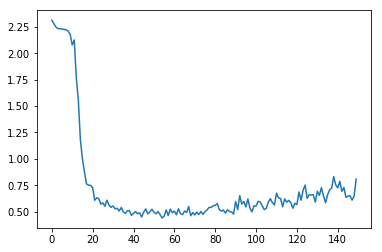

In [29]:
plt.plot(LL)
plt.show()

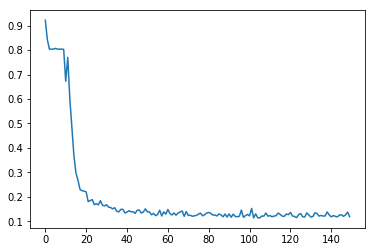

In [30]:
plt.plot(error)
plt.show()